In [1]:
# apt-get -y install libgl1-mesa-glx
# apt-get install libglib2.0-0
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
import torch
import random
import torch.nn.functional as F
import re

from diffusers import DPMSolverMultistepScheduler
from stablediffusion import StableDiffusionPipeline

from matplotlib import pyplot as plt

# Stable Diffusion Heatmapping

### Model Setting

In [2]:
def auto_device(obj = torch.device('cpu')):
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

    return obj

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)
    return gen

# Model loading...
model_id = "stabilityai/stable-diffusion-2-1"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
net = torch.nn.DataParallel(pipe).to(device)
pipe = net.module


prompt = "a photo of an astronaut riding a horse on mars"
# prompt = "a male nurse"

print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 6672.29it/s]


Current cuda device: 0
Count of using GPUs: 1


In [4]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (attn1): CrossAttention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features=320, bias=False)
                (to_out): ModuleList(
               

In [5]:
pipe.unet.mid_block.resnets[1]

ResnetBlock2D(
  (norm1): GroupNorm(32, 1280, eps=1e-05, affine=True)
  (conv1): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): Linear(in_features=1280, out_features=1280, bias=True)
  (norm2): GroupNorm(32, 1280, eps=1e-05, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
)

### Choosing the U-Net layer and Setting the hook register

In [3]:
import trace

# Hook Setting
gradients = dict()
activations = dict()

def backward_hook(module, grad_input, grad_output):
    print("Backwarding!!")
    gradients['value'] = grad_output[0]

def forward_hook( module, input, output):
    activations['value'] = output
# In the case of diffusion
pipe.unet.down_blocks[2].resnets[0].register_forward_hook(forward_hook)
pipe.unet.down_blocks[2].resnets[0].register_backward_hook(backward_hook)
# pipe.unet.conv_act.register_full_backward_hook(backward_hook)
# pipe.unet.mid_block.resnets[1].register_forward_hook(forward_hook)
# pipe.unet.mid_block.resnets[1].register_full_backward_hook(backward_hook)
# pipe.unet.up_blocks[3].resnets[2].conv2.register_forward_hook(forward_hook)
# pipe.unet.up_blocks[3].resnets[2].conv2.register_full_backward_hook(backward_hook)

layer_msg = "3rd Down Block 1st Resnet"

### Diffusion Grad Cam

In [4]:
def diffusion_gradcam(pipeline, prompt_txt, seed, num_step, step_vis, layer_message, save = False):
    
    out, logit, all_images = pipeline(
        prompt_txt,
        num_inference_steps=num_step,
        generator=set_seed(seed),
        get_images_for_all_inference_steps = True,
        output_type = None,
        step_visualization_num = step_vis
        )

    logit.sample.sum().backward()

    guidance_scale = 7.5

    grad_pred_uncond, grad_pred_text = gradients['value'].data.chunk(2)
    gradients_ = grad_pred_uncond + guidance_scale * (grad_pred_text - grad_pred_uncond)

    actv_pred_uncond, actv_pred_text = activations['value'].data.chunk(2)
    activations_ = actv_pred_uncond + guidance_scale * (actv_pred_text - actv_pred_uncond)
    b, k, u, v = activations_.size()
    # Mean of feature maps
    alpha = gradients_.view(b, k, -1).mean(2)
    weights = alpha.view(b, k, 1, 1)
    saliency_map = (weights * activations_).sum(1, keepdim=True)

    h = pipe.unet.config.sample_size * pipe.vae_scale_factor
    w = pipe.unet.config.sample_size * pipe.vae_scale_factor

    saliency_map = F.relu(saliency_map)

    # Upsampling
    saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)

    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    # normalization
    saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

    mask = saliency_map.cpu().data
    mask = (mask - mask.min()).div(mask.max() - mask.min()).data
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)

    noise_img = all_images[step_vis-1][0]
    org_img = out.images[0]

    raw_noise_img = cv2.resize(noise_img, (h, w), interpolation=cv2.INTER_LINEAR)
    raw_org_img = cv2.resize(org_img, (h, w), interpolation=cv2.INTER_LINEAR)

    # Image preprocessing
    
    # raw_img = np.float32(raw_img) / 255
    # img = raw_img.copy()[:, :, ::-1]
    noise_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_noise_img, (2, 0, 1))))
    org_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_org_img, (2, 0, 1))))

    transform_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    norm_noise_img = transform_norm(noise_img).unsqueeze(0)
    norm_org_img = transform_norm(org_img).unsqueeze(0)

    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # cam = heatmap + img.cpu()
    noise_cam = 1 * (1 - mask ** 0.8) * noise_img + (mask ** 0.8) * heatmap
    noise_gradcam = noise_cam.cpu().detach().squeeze(0)
    original_cam = 1 * (1 - mask ** 0.8) * org_img + (mask ** 0.8) * heatmap
    original_gradcam = original_cam.cpu().detach().squeeze(0)

    # Saving File
    save_pth = os.path.join("./outputs", re.sub(" ", "_",layer_msg))
    if not os.path.isdir(save_pth):
        os.mkdir(save_pth)

    # Visualization
    plt.figure('Grad Cam', figsize=(10,4))
    plt.suptitle(f"{layer_message} | total step:{num_step} | visualization:{step_vis}")
    plt.subplot(1,3,1)
    plt.title(f"Noise Grad Cam")
    plt.imshow(noise_gradcam.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title(f"Original Image")
    plt.imshow(org_img.permute(1, 2, 0))

    plt.subplot(1,3,3)
    plt.title(f"Original Grad Cam")
    plt.imshow(original_gradcam.permute(1, 2, 0))
    if save:
        plt.savefig(os.path.join(save_pth, f"{num_step}_{step_vis}.png"))
    plt.show()

    return all_images

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


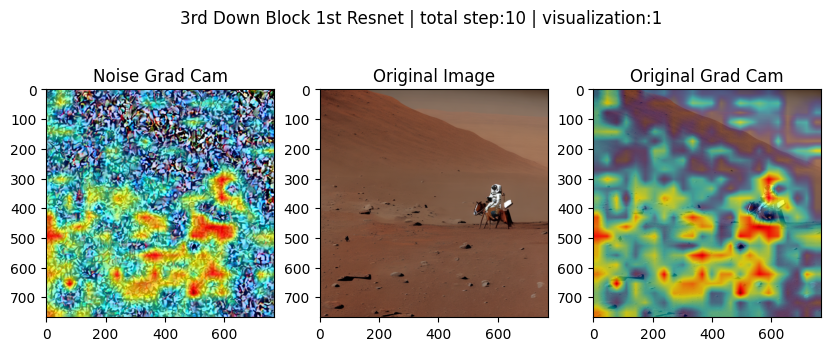

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


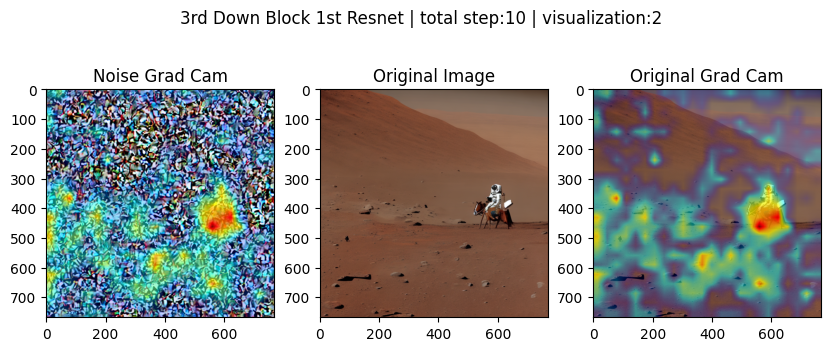

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


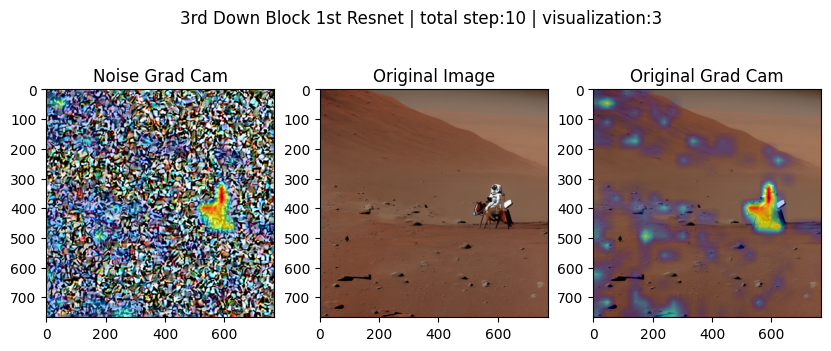

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


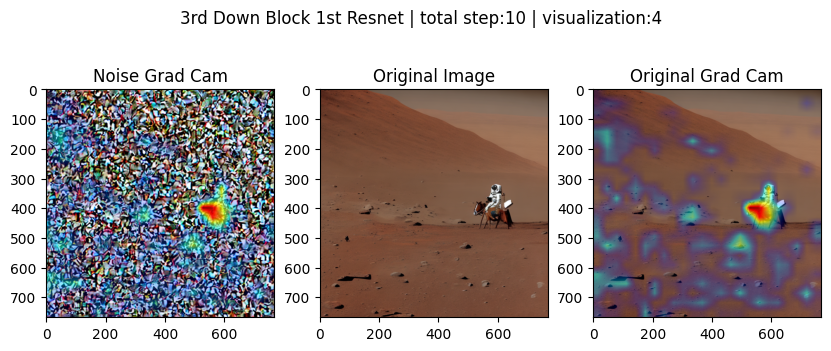

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


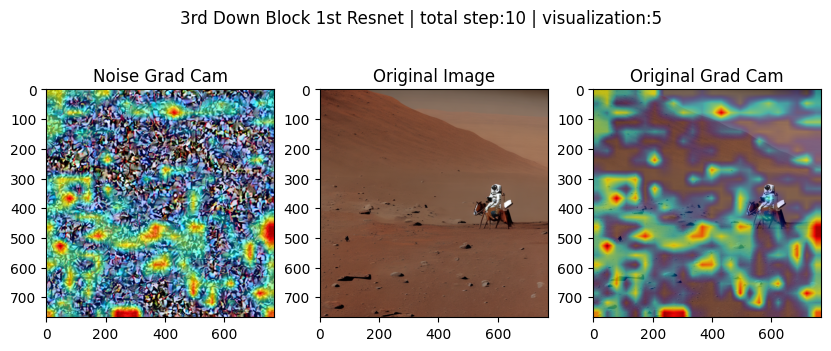

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


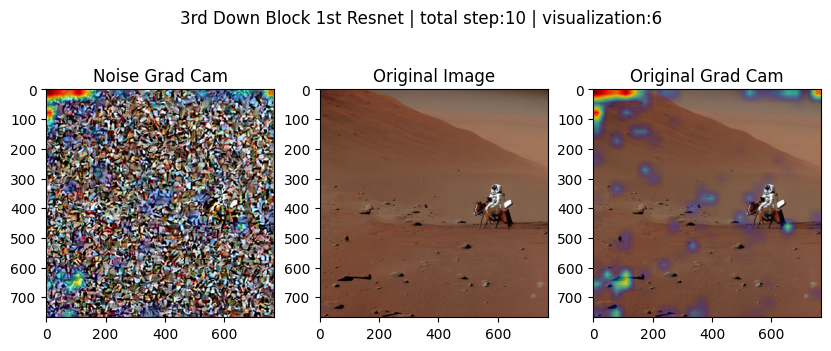

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


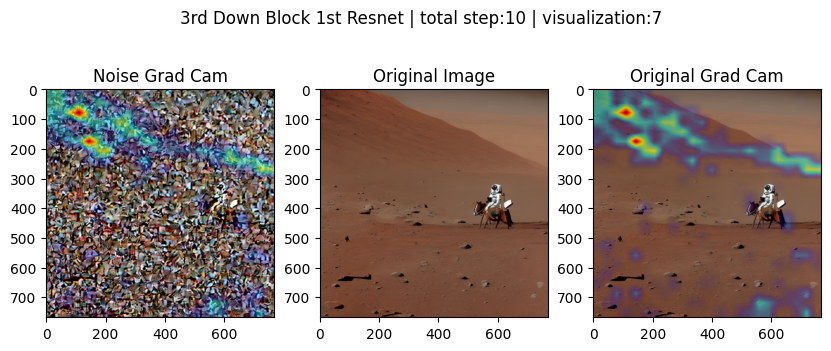

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


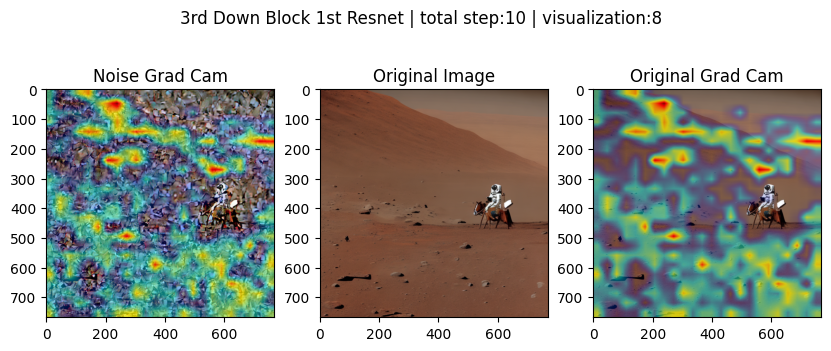

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


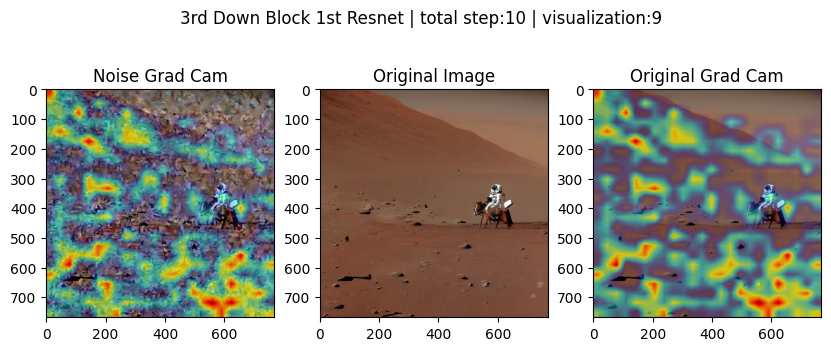

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


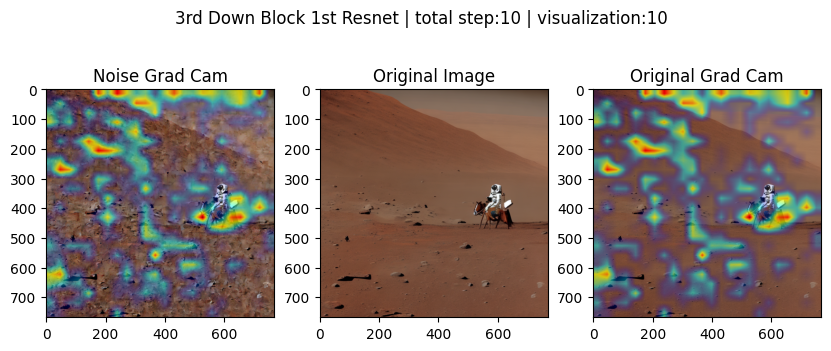

In [8]:
num_step = 10
for n in range(num_step):
    all_images = diffusion_gradcam(
        pipeline = pipe, 
        prompt_txt = prompt, 
        seed = 0, 
        num_step = num_step, 
        step_vis = n+1, 
        layer_message = layer_msg,
        save = False,
        )